In [1]:
import os
import sys
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

sys.path.append('..')
from semilearn.core.utils import get_net_builder, get_dataset, over_write_args_from_file
from semilearn.algorithms.openmatch.openmatch import OpenMatchNet
from semilearn.algorithms.iomatch.iomatch import IOMatchNet

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--c', type=str, default='')

def load_model_at(step='best'):
    args.step = step
    if step == 'best':
        args.load_path = '/'.join(args.load_path.split('/')[1:-1]) + "/model_best.pth"
    if step == 'latest':
        #args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/model_at_{args.step}_step.pth"
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/latest_model.pth"
    else:
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/"+str(step)+"_model.pth"
        
    print(args.load_path)
    checkpoint_path = os.path.join(args.load_path)
    checkpoint = torch.load(checkpoint_path)
    load_model = checkpoint['ema_model']
    load_state_dict = {}
    for key, item in load_model.items():
        if key.startswith('module'):
            new_key = '.'.join(key.split('.')[1:])
            load_state_dict[new_key] = item
        else:
            load_state_dict[key] = item
    save_dir = '/'.join(checkpoint_path.split('/')[:-1])
    if step == 'best':
        args.save_dir = os.path.join(save_dir, f"model_best")
    else:
        args.save_dir = os.path.join(save_dir, f"step_{args.step}")
    os.makedirs(args.save_dir, exist_ok=True)
    _net_builder = get_net_builder(args.net, args.net_from_name)
    net = _net_builder(num_classes=args.num_classes)
    if args.algorithm == 'openmatch':
        net = OpenMatchNet(net, args.num_classes)
    elif args.algorithm == 'iomatch':
        net = IOMatchNet(net, args.num_classes)
    else:
        raise NotImplementedError
    keys = net.load_state_dict(load_state_dict)
    print(f'Model at step {args.step} loaded!')
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    return net

In [3]:
def evaluate_open(net, dataset_dict, num_classes, extended_test=False):
    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    y_pred_closed_list = []
    y_pred_ova_list = []
    
    results = {}
    
    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']

            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()

            num_batch = y.shape[0]
            total_num += num_batch
            
            out = net(x)
            logits, logits_open = out['logits'], out['logits_open']    
            pred_closed = logits.data.max(1)[1]
            
            probs = F.softmax(logits, 1)
            probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
            unk_score = probs_open[tmp_range, 0, pred_closed]
            pred_open = pred_closed.clone()
            pred_open[unk_score > 0.5] = num_classes

            y_true_list.extend(y.cpu().tolist())
            y_pred_closed_list.extend(pred_closed.cpu().tolist())
            y_pred_ova_list.extend(pred_open.cpu().tolist())

    y_true = np.array(y_true_list)

    closed_mask = y_true < num_classes
    open_mask = y_true >= num_classes
    y_true[open_mask] = num_classes

    y_pred_closed = np.array(y_pred_closed_list)
    y_pred_ova = np.array(y_pred_ova_list)

    # Closed Accuracy on Closed Test Data
    y_true_closed = y_true[closed_mask]
    y_pred_closed = y_pred_closed[closed_mask]
    closed_acc = accuracy_score(y_true_closed, y_pred_closed)
    closed_cfmat = confusion_matrix(y_true_closed, y_pred_closed, normalize='true')
    results['c_acc_c_p'] = closed_acc
    results['c_cfmat_c_p'] = closed_cfmat  

    # Open Accuracy on Full Test Data
    open_acc = balanced_accuracy_score(y_true, y_pred_ova)
    open_cfmat = confusion_matrix(y_true, y_pred_ova)
    results['o_acc_f_hq'] = open_acc  
    results['o_cfmat_f_hq'] = open_cfmat
        
    if extended_test:
        with torch.no_grad():
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()

                num_batch = y.shape[0]
                total_num += num_batch

                out = net(x)
                logits, logits_open = out['logits'], out['logits_open']    
                pred_closed = logits.data.max(1)[1]

                probs = F.softmax(logits, 1)
                probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
                unk_score = probs_open[tmp_range, 0, pred_closed]
                pred_open = pred_closed.clone()
                pred_open[unk_score > 0.5] = num_classes

                y_true_list.extend(y.cpu().tolist())
                y_pred_closed_list.extend(pred_closed.cpu().tolist())
                y_pred_ova_list.extend(pred_open.cpu().tolist())
            
        y_true = np.array(y_true_list)

        open_mask = y_true >= num_classes
        y_true[open_mask] = num_classes
        y_pred_ova = np.array(y_pred_ova_list)
        
        # Open Accuracy on Extended Test Data
        open_acc = balanced_accuracy_score(y_true, y_pred_ova)
        open_cfmat = confusion_matrix(y_true, y_pred_ova, normalize='true')
        results['o_acc_e_hq'] = open_acc  
        results['o_cfmat_e_hq'] = open_cfmat
    
    #print(f"#############################################################\n"
              #f" Closed Accuracy on Closed Test Data: {results['c_acc_c_p'] * 100:.2f}\n"
              #f" Open Accuracy on Full Test Data:     {results['o_acc_f_hq'] * 100:.2f}\n"
              #f" Open Accuracy on Extended Test Data: {results['o_acc_e_hq'] * 100:.2f}\n"
              #f"#############################################################\n"
        #)
    
    return results

In [4]:
def evaluate_io(args, net, dataset_dict, extended_test=False):
    """
    evaluation function for open-set SSL setting
    """

    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    p_list = []
    pred_p_list = []
    pred_hat_q_list = []
    pred_q_list = []
    pred_q_prob_list=[]
    pred_hat_p_list = []

    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']
            #print('y',len(y),y)
            
            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()
            y_true_list.extend(y.cpu().tolist())

            num_batch = y.shape[0]
            total_num += num_batch

            outputs = net(x)
            logits = outputs['logits']
            logits_mb = outputs['logits_mb']
            logits_open = outputs['logits_open']

            # predictions p of closed-set classifier
            p = F.softmax(logits, 1)
            pred_p = p.data.max(1)[1]
            pred_p_list.extend(pred_p.cpu().tolist())

            # predictions hat_q from (closed-set + multi-binary) classifiers
            r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
            hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
            o_neg = r[tmp_range, 0, :]
            o_pos = r[tmp_range, 1, :]
            hat_q[:, :args.num_classes] = p * o_pos
            hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
            pred_hat_q = hat_q.data.max(1)[1]
            pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

            # predictions q of open-set classifier
            q = F.softmax(logits_open, 1)
            pred_q = q.data.max(1)[1]
            #print('p',p[0],'o_pos',o_pos[0])
            #print('q.data',q.data[0:10])
            #print('hatq.data',hat_q.data[0:10])
            #print('pred_q',pred_q)
            pred_q_prob = q.data
            pred_q_list.extend(pred_q.cpu().tolist())
            pred_q_prob_list.extend(pred_q_prob)

            # prediction hat_p of open-set classifier
            hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
            pred_hat_p = hat_p.data.max(1)[1]
            pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

        y_true = np.array(y_true_list)
        #print('y_true',len(y_true),y_true)
        closed_mask = y_true < args.num_classes
        open_mask = y_true >= args.num_classes
        #y_true[open_mask] = args.num_classes
        #print('pred_q[censys_index]',pred_q[censys_index])

        pred_p = np.array(pred_p_list)
        pred_hat_p = np.array(pred_hat_p_list)
        pred_q = np.array(pred_q_list)
        pred_hat_q = np.array(pred_hat_q_list)
        
        # closed accuracy of p / hat_p on closed test data
        c_acc_c_p = accuracy_score(y_true[closed_mask], pred_p[closed_mask])
        c_acc_c_hp = accuracy_score(y_true[closed_mask], pred_hat_p[closed_mask])
        set_label =  ['adscore',
 'ahrefs',
 'arbor',
 'archive',
 'binaryedge',

 'criminalip',
 'cybergreen',

 'fofa',
 'internet_census',
 'internettl',
 'intrinsec',
 'ipip',
 'leakix',
 'onyphe',
 'quadmetrics',
 'quake',
 'rapid7',
 'rau',
 'shadowserver',
 'shodan',
 'stretchoid',
 'tum',
 'webRay',
 'x_threatbook',
 'zoomeye',
'driftnet(added in unknown)',
 'unknown',
 'censys(added in unknown)'                     ]
 
        c_cfmat_c_p = confusion_matrix(y_true[closed_mask], pred_p[closed_mask])
        
        
        
        #print('y_true[closed_mask]',y_true[closed_mask])
        #print('pred_hat_p[closed_mask]',pred_hat_p[closed_mask])
        c_cfmat_c_hp = confusion_matrix(y_true[closed_mask], pred_hat_p[closed_mask], normalize='true')
        np.set_printoptions(precision=3, suppress=True)

        # open accuracy of q / hat_q on full test data
        o_acc_f_q = balanced_accuracy_score(y_true, pred_q)
        o_acc_f_q_f = f1_score(y_true, pred_q,average='weighted')
        o_acc_f_hq = balanced_accuracy_score(y_true, pred_hat_q)
        o_acc_f_hq_f = f1_score(y_true, pred_hat_q,average='weighted')
        o_cfmat_f_q = confusion_matrix(y_true, pred_q)
        o_cfmat_f_hq = confusion_matrix(y_true, pred_hat_q)
        
   
        index_list=list(set(y_true)|set(pred_q))
        label_list=[]
        for item in index_list:
            label_list.append(set_label[item])

        y_true_arr = y_true.copy()
        
        value_to_delete = 26
    
        mask = y_true != value_to_delete
        filtered_y_true = y_true_arr[mask]
        filtered_pred_q = pred_q[mask]
        o_acc_f_q_filtered = balanced_accuracy_score(filtered_y_true, filtered_pred_q)
        y_true_arr[open_mask] = args.num_classes
        filtered_y_true_open_masked = y_true_arr[mask]
        o_acc_f_q_filtered_masked = balanced_accuracy_score(filtered_y_true_open_masked, filtered_pred_q)
        


        o_acc_e_q = o_acc_e_hq = 0
        o_cfmat_e_q = None
        o_cfmat_e_hq = None

        if extended_test:
            unk_scores = []
            unk_scores_q = []
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()
                y_true_list.extend(y.cpu().tolist())

                num_batch = y.shape[0]
                total_num += num_batch

                outputs = net(x)
                logits = outputs['logits']
                logits_mb = outputs['logits_mb']
                logits_open = outputs['logits_open']

                # predictions p of closed-set classifier
                p = F.softmax(logits, 1)
                pred_p = p.data.max(1)[1]
                pred_p_list.extend(pred_p.cpu().tolist())

                # predictions hat_q of (closed-set + multi-binary) classifiers
                r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
                hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
                o_neg = r[tmp_range, 0, :]
                o_pos = r[tmp_range, 1, :]
                unk_score = torch.sum(p * o_neg, 1)
                hat_q[:, :args.num_classes] = p * o_pos
                hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
                pred_hat_q = hat_q.data.max(1)[1]
                pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

                # predictions q of open-set classifier
                q = F.softmax(logits_open, 1)
                pred_q = q.data.max(1)[1]
                pred_q_list.extend(pred_q.cpu().tolist())

                # prediction hat_p of open-set classifier
                hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
                pred_hat_p = hat_p.data.max(1)[1]
                pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

            y_true = np.array(y_true_list)
            open_mask = y_true >= args.num_classes
            y_true[open_mask] = args.num_classes

            pred_q = np.array(pred_q_list)
            pred_hat_q = np.array(pred_hat_q_list)

            # open accuracy of q / hat_q on extended test data
            o_acc_e_q = balanced_accuracy_score(y_true, pred_q)
            o_acc_e_hq = balanced_accuracy_score(y_true, pred_hat_q)
            o_cfmat_e_q = confusion_matrix(y_true, pred_q, normalize='true')
            o_cfmat_e_hq = confusion_matrix(y_true, pred_hat_q, normalize='true')

        eval_dict = {'c_acc_c_p': c_acc_c_p, 'c_acc_c_hp': c_acc_c_hp,
                     'o_acc_f_q': o_acc_f_q, 'o_acc_f_hq': o_acc_f_hq,
                     'o_acc_e_q': o_acc_e_q, 'o_acc_e_hq': o_acc_e_hq,
                     'c_cfmat_c_p': c_cfmat_c_p, 'c_cfmat_c_hp': c_cfmat_c_hp,
                     'o_cfmat_f_q': o_cfmat_f_q, 'o_cfmat_f_hq': o_cfmat_f_hq,
                     'o_cfmat_e_q': o_cfmat_e_q, 'o_cfmat_e_hq': o_cfmat_e_hq,
                     'pred_q_prob_list':pred_q_prob_list,
                     'o_acc_f_q_f':o_acc_f_q_f,
                     'label_list':label_list,
                     'o_acc_f_q_filtered':o_acc_f_q_filtered,
                     'pred_q':pred_q,
                     'pred_p':pred_p,
                     'y_true':y_true
                    }
        #print('fscore',o_acc_f_q_f,'f_hq',o_acc_f_hq_f)
        # print(f"#############################################################\n"
        #       f" Closed Accuracy on Closed Test Data (p / hp): {c_acc_c_p * 100:.2f} / {c_acc_c_hp * 100:.2f}\n"
        #       f" Open Accuracy on Full Test Data (q / hq):     {o_acc_f_q * 100:.2f} / {o_acc_f_hq * 100:.2f}\n"
        #       f" Open Accuracy on Extended Test Data (q / hq): {o_acc_e_q * 100:.2f} / {o_acc_e_hq * 100:.2f}\n"
        #       f"#############################################################\n"
        #     )

        return eval_dict

rm data/selfdeploy_24_25_1week_http_openset/labeled_idx/*
0
dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
idx_new [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
samples_per_class 100 idx [355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372
 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423

/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:01<00:00, 19.31it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c27f7f0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep5_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 80.65it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c27fa60> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep5_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 80.87it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67908630d0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep5_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 79.82it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790830400> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep4_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 78.31it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67acc393d0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep4_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 79.99it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c7d54f0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep4_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 79.77it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac197fa0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep4_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 69.00it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679082d340> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep3_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 80.38it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790863970> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep3_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 80.30it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790863f70> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep3_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 79.01it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c27fa30> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep3_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 77.90it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c7d54f0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 80.51it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac191a00> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 80.65it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67acc393d0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 79.38it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 540
dataset_data (540, 32, 32, 3)
dataset_data (9383, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c7d54f0> lb_dset 540
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_http_ep2_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 68.29it/s]


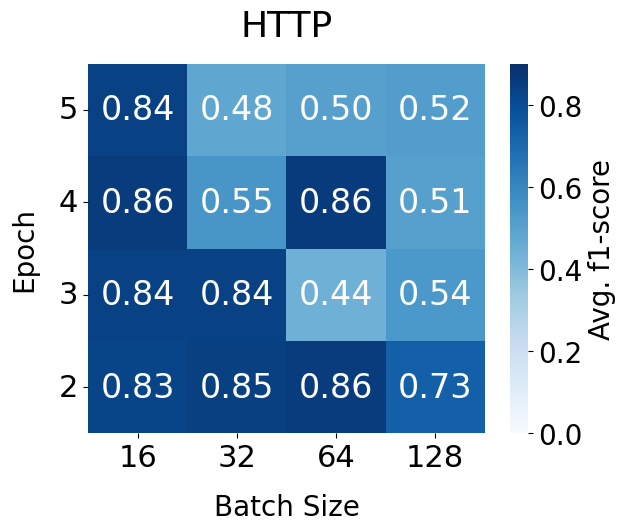

rm data/selfdeploy_24_25_1week_tls_openset/labeled_idx/*
0
dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157

/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cd21ca0> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep5_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 55.04it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67acc393d0> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep5_bs32/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 63.69it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ad49a9a0> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep5_bs64/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.19it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679082d790> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep5_bs128/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 65.55it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f696c27f640> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep4_bs16/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 58.01it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cd81e80> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep4_bs32/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.98it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cd21850> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep4_bs64/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.46it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67908196a0> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep4_bs128/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 65.11it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cd81e80> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep3_bs16/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.82it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cd7f820> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep3_bs32/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 65.65it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790819430> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep3_bs64/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 57.24it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679083eb80> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep3_bs128/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 63.18it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790819190> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs16/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.37it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790819550> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs32/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 63.71it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679083e670> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs64/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 63.72it/s]


dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
len_seen_indices 1159
dataset_data (1159, 32, 32, 3)
dataset_data (5458, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ad49a640> lb_dset 1159
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_tls_ep2_bs128/latest_model.pth


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.37it/s]


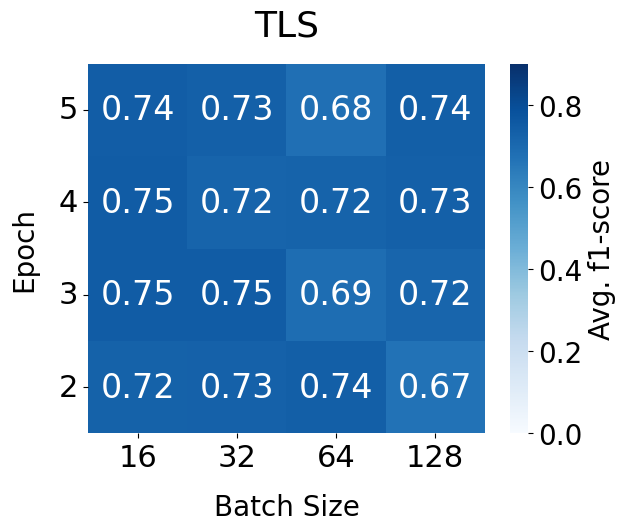

/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


rm data/selfdeploy_24_25_1week_dns_openset/labeled_idx/*
0
dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [38 39 40 41 42 43 44 45 46 47]
idx_new [38 39 40 41 42 43 44 45 46 47]
samples_per_class 100 idx [48 49 50 51 52 53 54 55 56 57]
idx_new [48 49 50 51 52 53 54 55 56 57]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109]
idx_new [ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109]
samples_per_class 100 idx [110 111 112 113 114 115 116 117 118 119 120 121 122 123]
idx_new [1

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 52.91it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679083e8e0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep5_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 53.80it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679083e670> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep5_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 58.09it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac1487c0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep5_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 56.54it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679083e8e0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep4_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 49.32it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f679083e670> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep4_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 58.98it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac1bc6a0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep4_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 56.18it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cbb72b0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep4_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 55.60it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790819430> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep3_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 50.06it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac17efa0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep3_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 57.44it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac1487c0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep3_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 54.89it/s]
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cb55fa0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep3_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 52.44it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f6790819490> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs16/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 45.11it/s]
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac17ed60> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 44.29it/s]
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ad49a640> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs64/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 54.27it/s]
/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check

dataset_name selfdeploy_24_25_1week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
len_seen_indices 204
dataset_data (204, 16, 16, 3)
dataset_data (3299, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f67ac1bc6a0> lb_dset 204
./saved_models/openset_cv/iomatch_selfdeploy_24_25_1week_dns_ep2_bs128/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 55.33it/s]


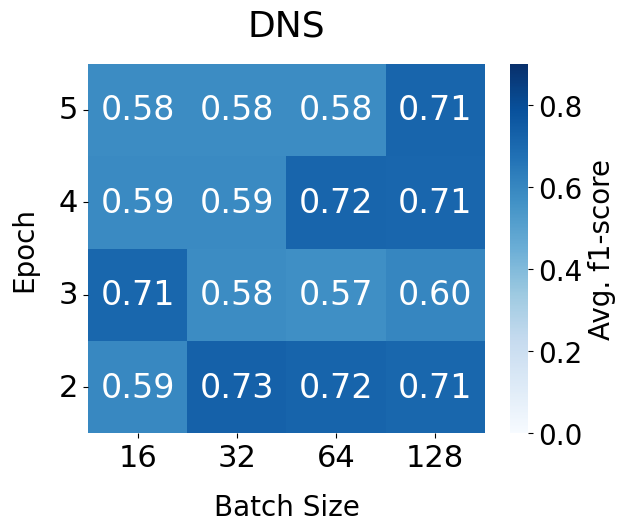

In [5]:


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

dataset_name='SelfDeploy25'

if(dataset_name=='SelfDeploy24'):
    start_date_str='2024-04-22'
    dataset='merge_month_2_4'
if(dataset_name=='SelfDeploy25'):
    start_date_str='2025-03-11'
    dataset='selfdeploy_24_25_1week'
    
for protocol in ['http','tls','dns']:

    cmd1='rm data/'+dataset+'_'+protocol+'_openset/labeled_idx/*'
    print(cmd1)
    r1=os.system(cmd1)
    print(r1)    
    config_name=dataset+'_'+protocol+'_incre.yaml'
    args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/'+config_name])
    over_write_args_from_file(args, args.c)
    args.data_dir = 'data'

    epoch_list=[5,4,3,2]
    batch_size_list=[16,32,64,128]
    
    results = np.zeros((len(epoch_list), len(batch_size_list)))
    for i,current_epoch in enumerate(epoch_list):
        for j,batch_size in enumerate(batch_size_list):
            args.bsz = batch_size
            args.load_path = "./saved_models/openset_cv/iomatch_"+dataset+"_"+protocol+"_ep"+str(current_epoch)+"_bs"+str(batch_size)+"/latest_model.pth"
            dataset_dict = get_dataset(args, args.algorithm, args.dataset,start_date_str, args.num_labels, args.num_classes, args.data_dir, eval_open=False)
            best_net = load_model_at('latest')#latest
            eval_dict = evaluate_io(args, best_net, dataset_dict)
            
        
            
            label_list=eval_dict['label_list']
            #,'CriminalIP',
            labels=label_list
            
            labels_x=label_list[:-3]+['unknown']
            
            value_to_delete = 26
            
            mask = eval_dict['y_true'] != value_to_delete
            filtered_y_true = eval_dict['y_true'][mask]
            filtered_pred_q = eval_dict['pred_q'][mask]
            filtered_y_true[filtered_y_true >25]=25
            
            f1_score_test=f1_score(filtered_y_true,filtered_pred_q,average='weighted')
            results[i, j] = f1_score_test
         
    
    row_labels = epoch_list
    col_labels = batch_size_list
    
    
    heatmap = sns.heatmap(
        results,
        annot=True,                
        fmt=".2f",                 
        cmap="Blues",              
        linewidths=0,             
        linecolor="white",         
        xticklabels=col_labels,
        yticklabels=row_labels,
        annot_kws={"size": 24},
        vmin=0,
        vmax=0.9
    )
    
    plt.title(protocol.upper(), fontsize=26, pad=20)
    plt.xlabel("Batch Size", fontsize=20, labelpad=15)
    plt.ylabel("Epoch", fontsize=20, labelpad=15)
    
    
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, fontsize=22)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=22)
    
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label("Avg. f1-score", fontsize=20)
    
    
    #plt.savefig('iomatch_incre_para/24_'+protocol+'.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()


rm data/merge_month_2_4_http_openset/labeled_idx/*
0
dataset_name merge_month_2_4
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
idx_new [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
samples_per_class 100 idx [507 508 509 510 511 512 513 514 515 516 517]
idx_new [507 508 509 510 511 512 513 514 515 516 517]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721]
idx_new [693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 7

/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 500
dataset_data (500, 32, 32, 3)
dataset_data (6075, 32, 32, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f694cd7f280> lb_dset 500
./saved_models/openset_cv/iomatch_merge_month_2_4_http_ep2_bs32/latest_model.pth
Model at step latest loaded!


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 65.60it/s]


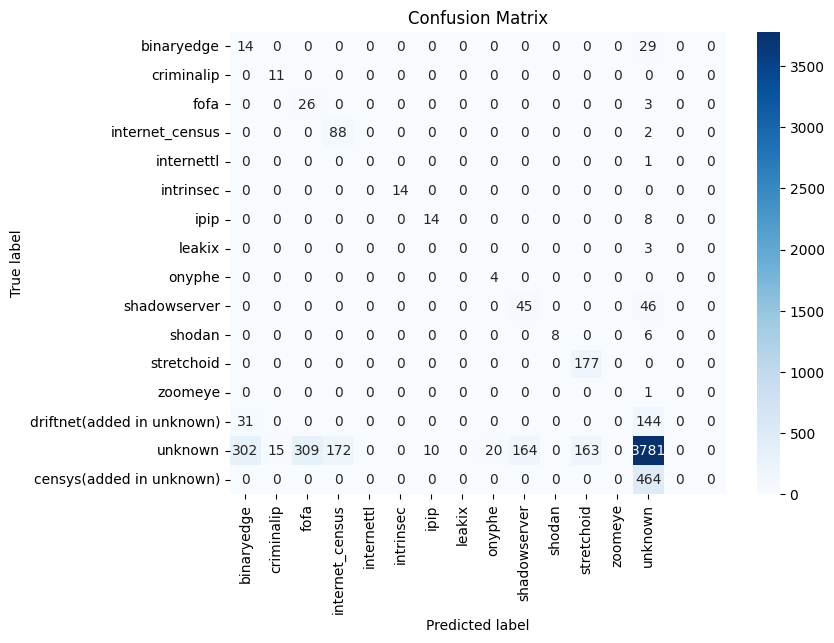

http f1_score_test 0.8787410758880297
      prediction              ip  groundtruth
0             25  206.189.233.69            4
1             25  206.189.233.69            4
2              4  206.189.233.69            4
3             25  173.230.141.69            4
4             25  173.230.141.69            4
...          ...             ...          ...
6070          25  180.101.244.16           26
6071          25  179.43.190.218           26
6072          25  179.43.190.218           26
6073          25    111.7.96.148           26
6074          25  118.123.105.93           24

[6075 rows x 3 columns]
rm data/merge_month_2_4_tls_openset/labeled_idx/*
0
dataset_name merge_month_2_4
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [  0   1   2   3   4   5   6   7   8   

/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step latest loaded!


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 59.55it/s]


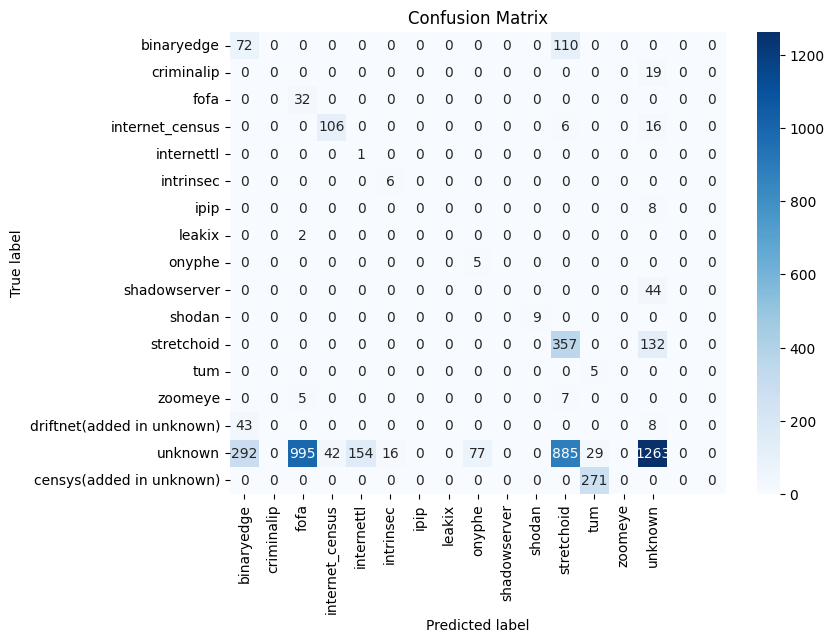

tls f1_score_test 0.49361658797653724
      prediction               ip  groundtruth
0              4   134.209.126.85            4
1              4   143.110.200.10            4
2              4    143.198.180.0            4
3              4  173.255.205.244            4
4              4    198.58.115.99            4
...          ...              ...          ...
5012          20    103.56.61.130           24
5013           7   118.123.105.92           24
5014           7   118.123.105.85           24
5015           7    103.56.61.130           24
5016           7    103.56.61.130           24

[5017 rows x 3 columns]


/tmp/ipykernel_1275899/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


rm data/merge_month_2_4_dns_openset/labeled_idx/*
0
dataset_name merge_month_2_4
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [44 45 46 47 48 49 50 51 52 53]
idx_new [44 45 46 47 48 49 50 51 52 53]
samples_per_class 100 idx []
idx_new []
samples_per_class 100 idx [ 54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
idx_new [ 54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
samples_per_class 100 idx [102]
idx_

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.73it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


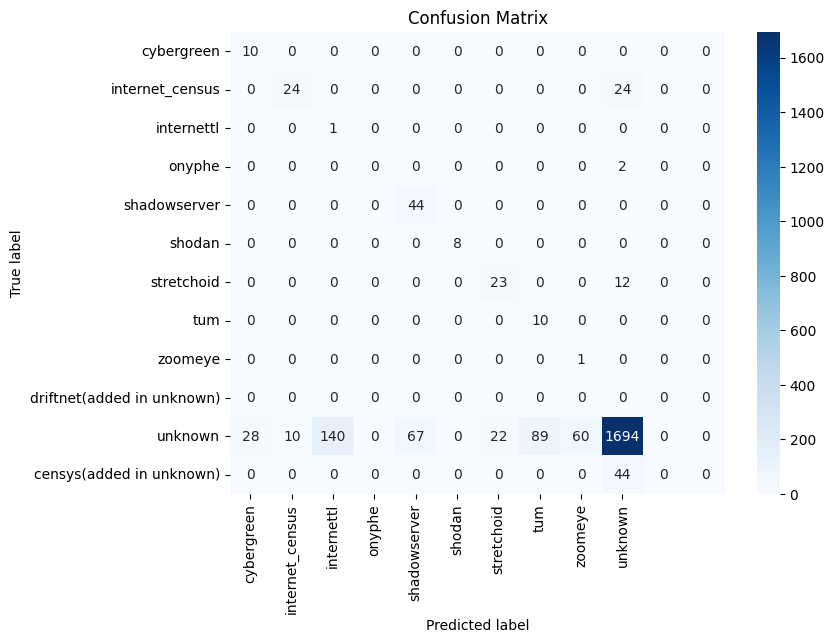

dns f1_score_test 0.8102895537921867
      prediction              ip  groundtruth
0             25  167.94.138.146           27
1             25  167.94.138.135           27
2             25  167.94.138.145           27
3             25  206.168.34.163           27
4             25  199.45.154.188           27
...          ...             ...          ...
2308          25   8.217.254.174           26
2309          21  129.204.254.94           26
2310          21  129.204.254.94           26
2311          21  129.204.254.94           26
2312          24  118.123.105.85           24

[2313 rows x 3 columns]


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

dataset_name='SelfDeploy24'

if(dataset_name=='SelfDeploy24'):
    start_date_str='2024-04-22'
    dataset='merge_month_2_4'
if(dataset_name=='SelfDeploy25'):
    start_date_str='2025-03-11'
    dataset='selfdeploy_24_25_1week'
    
for protocol in ['http','tls','dns']:#
    cmd1='rm data/'+dataset+'_'+protocol+'_openset/labeled_idx/*'
    print(cmd1)
    r1=os.system(cmd1)
    print(r1)    
    config_name=dataset+'_'+protocol+'_incre.yaml'#iomatch_cifar10_14000_28class_exp_month2_4_http_perservice_40dayscompletetrain_second
    args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/'+config_name])#test5#iomatch_cifar10_150_eval_25_n#iomatch_cifar10_14000_15class_comp_1
    over_write_args_from_file(args, args.c)#iomatch_cifar10_300_13_2class_comp_1#iomatch_cifar10_14000_13_2class_comp_1
    args.data_dir = 'data'

    epoch_list=[2]
    batch_size_list=[32]
    
    results = np.zeros((len(epoch_list), len(batch_size_list)))
    for i,current_epoch in enumerate(epoch_list):
        for j,batch_size in enumerate(batch_size_list):
            args.bsz = batch_size
            args.load_path = "./saved_models/openset_cv/iomatch_"+dataset+"_"+protocol+"_ep"+str(current_epoch)+"_bs"+str(batch_size)+"/latest_model.pth"
            dataset_dict = get_dataset(args, args.algorithm, args.dataset,start_date_str, args.num_labels, args.num_classes, args.data_dir, eval_open=False)
            best_net = load_model_at('latest')#latest
            eval_dict = evaluate_io(args, best_net, dataset_dict)
            
        
            
            label_list=eval_dict['label_list']
            #,'CriminalIP',
            labels=label_list
            
            labels_x=label_list[:-3]+['unknown']
            
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(eval_dict['o_cfmat_f_q'], annot=True, cmap='Blues', fmt='g',xticklabels=labels_x,yticklabels=labels)#, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']
            plt.xlabel('Predicted label')
            plt.ylabel('True label')
            plt.title('Confusion Matrix')
            plt.show()
            

            
            value_to_delete = 26
            
            
            mask = eval_dict['y_true'] != value_to_delete
            filtered_y_true = eval_dict['y_true'][mask]
            filtered_pred_q = eval_dict['pred_q'][mask]
            filtered_y_true[filtered_y_true >25]=25
            
            #report=classification_report(filtered_y_true,filtered_pred_q,target_names=label_list[:-3]+['driftnet+censys(added in unknown)'])
            #print(report)
            f1_score_test=f1_score(filtered_y_true,filtered_pred_q,average='weighted')
            print(protocol,'f1_score_test',f1_score_test)
            results[i, j] = f1_score_test

    
            import numpy as np
            import pandas as pd
            import pickle
            
            
            if('http' in config_name):
                proto='http'
            if('tls' in config_name):
                proto='tls'
            if('dns' in config_name):
                proto='dns'
            if('ssh' in config_name):
                proto='ssh'
            if('rdp' in config_name):
                proto='rdp'
                
            name=dataset
            if (dataset_name=='SelfDeploy24'):
                mode='test'
                npy_path1 = '../dataset/npy/ip_array_'+proto+'_'+name+'_'+mode+'.npy'
            else:
                mode=''
                npy_path1 = '../dataset/npy/ip_array_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.npy'
            #npy_path2 = 'label_array_'+proto+'_'+name+'_'+mode+'.npy'
            #dataset = NumpyDataset(npy_path1,npy_path2)
            
            loaded_array = np.load(npy_path1,allow_pickle=True)
            loaded_array
            len(loaded_array)
        
            mask = ~np.isin(loaded_array, ['192.168.1.0', '192.168.2.0','192.168.3.0','192.168.4.0','192.168.5.0'])
            loaded_array = loaded_array[mask]
            
            pred = eval_dict['pred_q']
            pred = pred[mask]
            
            y_true = eval_dict['y_true']
            y_true = y_true[mask]
            
            
            df = pd.DataFrame({'prediction': pred, 'ip': loaded_array,'groundtruth':y_true})
            
            print(df)
        
           
        
            df.to_csv('result_'+proto+'_'+name+'_'+mode+'.csv', index=False)
            
            
            
            
            
            test_dns_label_dic = {}
            
            for value, group_df in df.groupby('ip'):
                test_dns_label_dic[value] = group_df
                
            test_dns_label_dic_common={}
            for i in test_dns_label_dic.keys():
                test_dns_label_dic_common[i]=test_dns_label_dic[i]['prediction'].mode().values[0]
            
            def protocol_level_prediciton(ip_train2,y_train2,train2_label_dic_common):
                a=pd.DataFrame()
                a['ip']=ip_train2
                a['label']=y_train2
                a['pred_label']=None
                a=a.drop_duplicates()
                
                for index, row in a.iterrows():
                    a.loc[index,'pred_label']=train2_label_dic_common[row['ip']]
                #print(a)
                return a
            df_ip_dns_test=protocol_level_prediciton(loaded_array,y_true,test_dns_label_dic_common)
            df_ip_dns_test=df_ip_dns_test.rename(columns={'pred_label':'pred_label_'+proto})
        
            with open('proto_level_7daysegment_pred_'+proto+'_'+name+'_'+mode+'_'+start_date_str+'.pkl', 'wb') as f:
                pickle.dump(df_ip_dns_test, f)
         

    
